In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The purpose of this notebook is to categorize meal titles (category_id == 2) into more "meaningful" categories.
## One hypothesis is that understanding what kind of meals exist, will help us understand the kind of "order" there is or how many people there are.

### The potential categories we are interested in are: 
- small/apetizer meals
    - this will be decided based on price of meal. Meals in the price ranges of ~0-6$ tend to be smaller meals that may be considered starters. The goal is to identify such meals and not count them as "whole" item meals as we would a meal per person. This could potentially help us get a more accurate estimate of "guest count".
   
   
- Sharable Meals
    - this will be decided based on a dictinoary of common "sharable" meal types. This means that the meal is usually shared by more than one person when ordered, such as: pizza, fries, wings, nachos.


In [4]:
df = pd.read_csv("../data/df_august.csv")

df['order_time'] = pd.to_datetime(df['order_time'], format='%Y-%m-%d %H:%M:%S.%f')
df['order_hour'] = df.order_time.apply(lambda ticket: int(ticket.hour))
df['order_day_of_week'] = df.order_time.apply(lambda ticket: ticket.day_name())

In [5]:
df.columns

Index(['bar_id', 'order_id', 'order_time', 'order_item_id', 'title',
       'category_id', 'beer_brand_id', 'beer_serving_type_id', 'beer_volume',
       'item_qty', 'sales_before_tax', 'sales_inc_tax', 'guest_count',
       'timezone', 'bar_type_id', 'bar_type', 'total_orders',
       'total_orders_category_id_1.0', 'total_orders_category_id_2.0',
       'total_orders_category_id_3.0', 'total_orders_category_id_4.0',
       'total_orders_category_id_5.0', 'total_orders_category_id_6.0',
       'order_hour', 'order_day_of_week'],
      dtype='object')

In [6]:
df = df.groupby('order_id', as_index=False).agg({'bar_id': "mean", 'order_time':"max", 
'sales_inc_tax':"sum", 'guest_count':"mean",'bar_type_id':"mean", 'total_orders':"mean", 'item_qty':"sum",
'total_orders_category_id_1.0':"mean", 'total_orders_category_id_2.0':"mean", 'total_orders_category_id_3.0':"mean",
'total_orders_category_id_4.0':"mean", 'total_orders_category_id_5.0':"mean", 'total_orders_category_id_6.0':"mean",
'kids_meal':"max", 'birthday':"max", 'bar_type':"max", "beer_volume":"sum", "day_of_week":"mean",
'beer_brand_id':"list", 'beer_serving_type_id':"list","sharable_meal":"mean",
'bar_type_id':"mean", 'total_orders':"sum", 'order_hour':"mean", 'order_day_of_week':"mean"})

/Users/danielastepanov/miniconda3/envs/ds/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'kids_meal'

## How many food items do we have?

In [186]:
df2 = df[df.category_id == 2]
len(df2["title"].value_counts()) 

27621

In [187]:
df2.info() #almost half of the original dataset are food items

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787293 entries, 0 to 1754368
Data columns (total 23 columns):
bar_id                          787293 non-null int64
order_id                        787293 non-null int64
order_time                      787293 non-null object
order_item_id                   787293 non-null int64
title                           787293 non-null object
category_id                     787293 non-null float64
beer_brand_id                   787293 non-null int64
beer_serving_type_id            787293 non-null int64
beer_volume                     787192 non-null float64
item_qty                        787293 non-null float64
sales_before_tax                787293 non-null float64
sales_inc_tax                   787293 non-null float64
guest_count                     787293 non-null int64
timezone                        787293 non-null object
bar_type_id                     787293 non-null int64
bar_type                        717898 non-null object
total_orde

### Lets clean the titles using Karins code

### first, lets refine a bit some of the rules for removing titles.

For example, the word "sauce" is inside some food items that are not actually a sauce, but a meal.

In [142]:
# titles with the word "sauce" in there from previous code
sauces

{'$  side sauce',
 '$ sauce',
 '$ wing/rib sauce',
 '$$hot sauce',
 '$$med sauce',
 '$$rabbid sauce$$',
 '$$tossed in sauce',
 '(-chou + sauce)',
 '(-coleslaw + sauce)',
 '(sauce a part)',
 '* mix sauces',
 '**lightly sauced**',
 '**mix sauces**',
 '**sep sauces**',
 '*-sauce*',
 '*-sauce+ chou*',
 '*-sauce+fries*',
 '*-sauce+frites*',
 '*-sauce+pain*',
 '*>sauce a part',
 '*sauce a volonte*',
 '*sauce hot',
 '*side tomato sauce',
 '*wing sauce',
 '+ large plum sauce',
 '+ mushroom sauce',
 '+ sauce',
 '+ small hot sauce',
 '+sm sauce',
 '- no sauce',
 '-- alfredo sauce',
 '-- meat sauce',
 '-- tomato sauce',
 '-> bbq sauce',
 '-> lightly sauced',
 '-> meat sauce',
 '-> tomato sauce',
 '->hurleys bbq sauce',
 '->marinara sauce',
 '->marinera sauce',
 '->meat sauce',
 '->no bbq sauce',
 '->no sauce',
 '->sauce on side',
 '-caramel sauce',
 '-chocolate sauce',
 '-no sauce',
 '-s/o hot sauce',
 '-sauce o/s',
 '1/2 sauce viande',
 '10 oz meat sauce',
 '2 oz wing sauce',
 '2 oz.wing sauce',

#### This list of foods should not be included in the filtering of the sauces, since there are very popular foods that we will be removing if we remove everythign with "sauce" in it.

In [4]:
foods_w_sauce = ["fingers", "spaghetti", "poutine", "wings", "pate", "bowl", "fries", "rigatoni", "pasta",
                "linguini", "frite"]
remove_w_sauce = ["no wing", "for wing", "on", "side"]

We want to also look at the titles with "sub" in them to see if we can safely remove

In [162]:
subs = df[df.title.apply(lambda x: "sub" in x.lower())]

In [179]:
subs[subs['sales_before_tax'] == 0]

,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,...,timezone,bar_type_id,bar_type,total_orders,total_orders_category_id_1.0,total_orders_category_id_2.0,total_orders_category_id_3.0,total_orders_category_id_4.0,total_orders_category_id_5.0,total_orders_category_id_6.0
3994,1275,651637840,2019-07-20 14:36:00.000,65163784010,$Sub.Poutine,5.0,0,0,0.0,1.0,...,America/Toronto,8,Casual Bar,21,0,8,0,8,4,0
12363,7273,651449652,2019-07-20 09:23:33.000,65144965201,Subs for Take 2,2.0,0,0,0.0,1.0,...,America/Toronto,0,NaN,3,0,3,0,0,0,0
12421,7273,651554999,2019-07-20 11:50:22.000,65155499901,Subs for Take 2,2.0,0,0,0.0,1.0,...,America/Toronto,0,NaN,6,0,6,0,0,0,0
12426,7273,651554999,2019-07-20 11:50:22.000,65155499904,Subs for Take 2,2.0,0,0,0.0,1.0,...,America/Toronto,0,NaN,6,0,6,0,0,0,0
13200,4016,651812793,2019-07-20 19:54:12.000,65181279304,SUB VEGGIE PATTY,NaN,0,0,0.0,1.0,...,America/Toronto,0,NaN,10,0,6,0,1,1,1
16413,1275,650201399,2019-07-18 19:09:00.000,65020139904,$Sub.Poutine,5.0,0,0,0.0,1.0,...,America/Toronto,8,Casual Bar,7,0,3,1,2,1,0
18726,4016,651547403,2019-07-20 11:19:07.000,65154740310,SUB RANCH,5.0,0,0,0.0,1.0,...,America/Toronto,0,NaN,26,18,4,0,0,4,0
26939,30058,650470756,2019-07-18 15:58:56.000,65047075601,Sub.side Ceaser,2.0,0,0,0.0,1.0,...,America/Toronto,1,Bar/Pub,3,0,2,1,0,0,0
26990,30058,650470927,2019-07-18 20:58:27.000,65047092700,Sub.side Garden,2.0,0,0,0.0,1.0,...,America/Toronto,1,Bar/Pub,8,2,3,0,1,0,2
27124,30058,650470673,2019-07-18 12:24:47.000,65047067301,Sub.side Garden,2.0,0,0,0.0,1.0,...,America/Toronto,1,Bar/Pub,3,0,2,0,1,0,0


#### It seems that most items that have the word "sub" in there, and the price is zero we can safely remove.

In [5]:
sauces = set()
sub = set()
# drop unrelevant titles
def filter_titles(row):
    title = row["title"].lower()
    price = row["sales_before_tax"]

    if "xtra" in title:
        return False
    if "sub" in title and price == 0:
        sub.add(title)
        return False
    elif "add" in title:
        return False
    elif "sauce" in title:
        for t in foods_w_sauce: 
            if t in title: return True
        for t in remove_w_sauce:
            if t in title: return False
        sauces.add(title)
        return False
    elif "no " in title:
        return False
    elif "no." in title:
        return False
    elif "-no " in title:
        return False
    elif "side " in title:
        return False
    elif "+" in title:
        return False
    elif "dip" in title:
        return False
    elif "blue cheese" in title:
        return False
    elif "bbq" in title:
        return False
    elif "n/c" in title:
        return False
    elif "s/o" in title:
        return False
    elif title == '' or title == 'garlic.aioli' or title == 'gluten' or title == 'hot n honey' or title == 'honey garlic' or title == 'kids.' or title == 'to go':
        return False
    else:
        return True

dfc = df[df.apply(lambda x: filter_titles(x), axis=1)]

In [6]:
df2 = dfc[dfc.category_id == 2]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700248 entries, 0 to 1754368
Data columns (total 25 columns):
bar_id                          700248 non-null int64
order_id                        700248 non-null int64
order_time                      700248 non-null datetime64[ns]
order_item_id                   700248 non-null int64
title                           700248 non-null object
category_id                     700248 non-null float64
beer_brand_id                   700248 non-null int64
beer_serving_type_id            700248 non-null int64
beer_volume                     700147 non-null float64
item_qty                        700248 non-null float64
sales_before_tax                700248 non-null float64
sales_inc_tax                   700248 non-null float64
guest_count                     700248 non-null int64
timezone                        700248 non-null object
bar_type_id                     700248 non-null int64
bar_type                        636594 non-null object
to

In [238]:
len(df2["title"].value_counts())

24410

### This is good, we lost ~87k items from the original data, but our overall unique food items stayed roughly the same. Meaning we did't lose any whem filtering the sauces and mistakes in the titles.

In [239]:
df2.isnull().sum()

bar_id                              0
order_id                            0
order_time                          0
order_item_id                       0
title                               0
category_id                         0
beer_brand_id                       0
beer_serving_type_id                0
beer_volume                       101
item_qty                            0
sales_before_tax                    0
sales_inc_tax                       0
guest_count                         0
timezone                            0
bar_type_id                         0
bar_type                        63654
total_orders                        0
total_orders_category_id_1.0        0
total_orders_category_id_2.0        0
total_orders_category_id_3.0        0
total_orders_category_id_4.0        0
total_orders_category_id_5.0        0
total_orders_category_id_6.0        0
order_hour                          0
order_day_of_week                   0
dtype: int64

A little less than 10% are missing bar types

## Lets look at the most popular items

In [8]:
df2["title"].value_counts()[:30]

CALAMARI            7966
FINGERS.SAUCED      6981
WINGS               6387
QUESA.STACK         5457
JACKS.VEG.NACHOS    5178
CHICKEN.FINGERS     5147
MAC 'N CHEESE       4574
HOLY.SMOKE.BURGR    4401
QUESADILLAS         4140
POUTINE             4140
ASIAGO.BOWTIE       4082
WINGS.10PC          3618
NACHOS              2912
WORKS BURGER        2865
BRUSCHETTA.         2835
LE CONSTRUCTEUR     2610
SKIP.ORD.#          2374
SESAME CHICKEN      2299
CHK.PARMIGIANA      2294
BUDDHA.SALAD        2294
CHICKEN.CLUB        2289
TRAD.GUAC           2268
MEXI.SALAD          2174
---SEAT             2117
PEROGIES            2073
K.COOKIE            2037
FISH'N'CHIPS        2024
DBL.BAC.CHSBRG      1867
K.BROWNIE           1798
WED WING            1785
Name: title, dtype: int64

In [9]:
top_foods = df2["title"].value_counts().index[:20]

### If you look closely at the top titles, one thing they have in common is that they are very typical "bar foods". Meaning they are very traditional for "Beer" bars that serve foods that are common to share.

### But! we also need to make sure they are not coming from one bar and see from what bar types, so lets see.


In [10]:
df_bars = df2[df2.title.isin(top_foods)]

In [12]:
len(df2)

700248

In [14]:
df2["bar_type"].value_counts(normalize=True)

Bar/Pub                 0.488753
Casual Dining           0.252541
Restaurant              0.089088
Trendy Restaurant       0.070940
Casual Bar              0.023136
Hotel                   0.020892
Trendy Bar              0.013679
Beer Bar / Pub          0.012886
Sports Bar              0.012870
Restaurante informal    0.005176
Club - Sports           0.003732
Pizzería/Restaurante    0.002270
Fine Dining             0.002041
Trendy Bar/Pub          0.000955
Party POC               0.000925
Lounge                  0.000116
Name: bar_type, dtype: float64

### So, 55% of the foods appear in casual dining, not that surprising. 19% come from Bar/pubs and another 12 from restaurants.

### BTW, is this also true for beer items?

In [29]:
df3 = dfc[dfc.category_id == 1]
df3["title"].value_counts()[:20]

CORONA              7955
MILL ST ORG.Pt      3795
CORONA BTL          3575
BELGIAN.MOON..Pt    3522
STELLA.Pt           3344
BUDWEISER TAP       3059
BUDWEISER.Pt        2824
BELGIAN.MOON..XL    2668
MILL ST ORG.XL      2563
BUD LIGHT           2404
LIGHT               2220
BLD WRHSE TAP       2118
BUDWEISER.XL        2076
BUDWEISER           1930
BUD                 1805
COORS.LIGHT.XL      1797
GOOSE.IPA.Pt        1788
GOOSE IPA TAP       1614
BCKT.4.CORONA       1481
GOOSE.IPA.XL        1431
Name: title, dtype: int64

In [250]:
df3["bar_type"].value_counts(normalize=True)

Bar/Pub                 0.572745
Casual Dining           0.199404
Restaurant              0.056701
Trendy Restaurant       0.047733
Casual Bar              0.036851
Trendy Bar              0.032722
Beer Bar / Pub          0.016359
Sports Bar              0.015018
Hotel                   0.012394
Club - Sports           0.003248
Trendy Bar/Pub          0.003074
Restaurante informal    0.001138
Pizzería/Restaurante    0.001124
Fine Dining             0.000930
Party POC               0.000490
Lounge                  0.000069
Name: bar_type, dtype: float64

### 57% of the beer in our data is consumed in Bar/Pub type of places, while 20% is in casual dining. 
### Very interesting :) almost exactly the same numbers as food is for casual dining, beer is for bar/pub. b

## Also - I think it is same to assume that if we'd only focus on Bar/pub and Casual dining we would cover a large portion of beer consumption.

### Just of of curiosity, are there different beers consumed in bar/pub and restaurants?

In [251]:
df3[df3.bar_type == "Bar/Pub"]["title"].value_counts()[:10]

CORONA             5125
BUDWEISER TAP      2972
LIGHT              1783
BUD LIGHT          1293
BUDWEISER          1288
MILL ST ORG TAP    1272
LOYALTY PINT       1221
GOOSE IPA TAP      1127
SHOCK TOP TAP      1088
BUD                1075
Name: title, dtype: int64

In [252]:
df3[df3.bar_type == "Casual Dining"]["title"].value_counts()[:10]

MILL ST ORG.Pt      3011
BELGIAN.MOON..Pt    2727
CORONA BTL          2385
STELLA.Pt           2342
BELGIAN.MOON..XL    2229
BUDWEISER.Pt        2165
MILL ST ORG.XL      2022
BUDWEISER.XL        1642
GOOSE.IPA.Pt        1485
COORS.LIGHT.XL      1392
Name: title, dtype: int64

#### Lets do what Karin did and see by days of week!

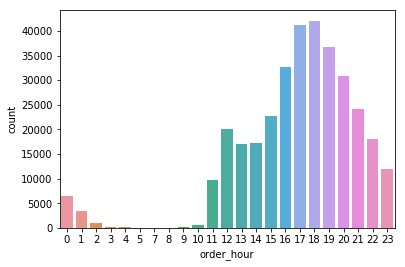

In [30]:
sns.countplot(x='order_hour', data=df3)

In [ ]:
# 1. beer
# 2. food
# 3. liquer and alcohol
# 4. soft drinks
# 5. side dishes
# 6. cocktails and wine

popular_beers = ["corona", ""]
plt.figure(figsize=(10,7))
pv = df.pivot_table(values= "order_id", columns ="category_id", index="order_time",aggfunc="count", fill_value =0)
pv.columns = ["beer", "food", "liquer & alcohol", "soft drinks", "side dishes", "cocktails & wine"]
pv.index = ["morning", "afternoon", "evening", "night"]

pv = sns.heatmap(pv, annot=True, fmt = "d")

## Interesting :) although theres less variaty of items in beers than foods, (could also be due to variety of spelling in foods) it seems there more traditional bar  beers are consumed in bars, whereas maybe the more belgian beers are consumed at restaurants. (But their differences are also not that big)

# alright back to foods! Lets create a dictionary for popular sharable foods, and decide on the price for small plates.

In [15]:
remove = []
for k,v in df2["title"].value_counts().to_dict().items():
    if v <= 100:
        remove.append(k)
df22 = df2[~df2.title.isin(remove)]

In [276]:
len(df22.title.value_counts())

1029

In [270]:
len(remove)

22241

In [16]:
df22["title"].value_counts()

CALAMARI               7966
FINGERS.SAUCED         6981
WINGS                  6387
QUESA.STACK            5457
JACKS.VEG.NACHOS       5178
CHICKEN.FINGERS        5147
MAC 'N CHEESE          4574
HOLY.SMOKE.BURGR       4401
QUESADILLAS            4140
POUTINE                4140
ASIAGO.BOWTIE          4082
WINGS.10PC             3618
NACHOS                 2912
WORKS BURGER           2865
BRUSCHETTA.            2835
LE CONSTRUCTEUR        2610
SKIP.ORD.#             2374
SESAME CHICKEN         2299
CHK.PARMIGIANA         2294
BUDDHA.SALAD           2294
CHICKEN.CLUB           2289
TRAD.GUAC              2268
MEXI.SALAD             2174
---SEAT                2117
PEROGIES               2073
K.COOKIE               2037
FISH'N'CHIPS           2024
DBL.BAC.CHSBRG         1867
K.BROWNIE              1798
WED WING               1785
                       ... 
Winks Breakfast         104
BURGER CHAMP. SAUV.     104
REMPL.BOIGAZ            104
GRAND BURGER            104
SM. CAESAR          

In [21]:
sharable_foods = [
    "pizza", "cake", "hot pot", "nachos", "guac", "wings", "Focaccia", "bread", "fries", "pretzels",
"quesadilla", "nuts", "fondue", "calamari", "fingers sauced","chicken fingers", "chkn fingers", "quesa stack" 
]

In [19]:
def find_sharable(title):
    title = " ".join(title.lower().split("."))
    for s in sharable_foods:
        if s in title:
            return 1
    return 0

In [2]:
df2.columns

NameError: name 'df2' is not defined

In [22]:
df2["sharable"] = df2.title.apply(lambda x: find_sharable(x))

/Users/danielastepanov/miniconda3/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
df2[df2.sharable == 1].title

11                 Chicken Nachos
22               JACKS.VEG.NACHOS
24                    QUESA.STACK
102                  CARNE NACHOS
115                   BEEF.NACHOS
124                FINGERS.SAUCED
140            BASKET CURLY FRIES
160                   QUESA.STACK
178               Chicken Fingers
215                FINGERS.SAUCED
226                 1/2 EL NACHOS
248                     TRAD.GUAC
300        Home Fries instd Fries
355                   QUESA.STACK
356                   QUESA.STACK
365                  Basket Fries
388                   QUESA.STACK
393                   QUESA.STACK
395                   QUESA.STACK
402               Salad ins Fries
417                   QUESA.STACK
419                   QUESA.STACK
435                CAJUN CALAMARI
438                   QUESA.STACK
439               CHICKEN.FINGERS
456                  TWELVE WINGS
468           NACHOS CAFECO JEUDI
471                  RIBS & WINGS
490                      CALAMARI
496           

### Looks like I got pancakse! :P

In [313]:
df2.rename(columns={'bar_type_Casual Dining':'bar_type_casual_dining', 'bar_type_Bar/Pub':'bar_type_bar_pub', 'bar_type_Restaurant':'bar_type_restaurant', 'bar_type_Casual Bar':'bar_type_casual_bar',
       'bar_type_Beer Bar / Pub':'bar_type_beer_bar_pub', 'bar_type_Trendy Bar':'bar_type_trendy_bar', 'bar_type_Club - Sports':'bar_type_club_sports',
       'bar_type_Trendy Restaurant':'bar_type_trendy_restaurant', 'bar_type_Hotel':'bar_type_hotel', 'bar_type_Fine Dining':'bar_type_fine_dining',
       'bar_type_Restaurante informal':'bar_type_restaurante_informal', 'bar_type_Sports Bar':'bar_type_sports_bar', 'bar_type_Pizzería/Restaurante':'bar_type_pizzería_restaurante',
       'bar_type_Trendy Bar/Pub':'bar_type_trendy_bar_pub', 'bar_type_Party POC':'bar_type_party_poc', 'bar_type_Lounge':'bar_type_lounge'}, inplace=True)
df2 = df2[df2.bar_type.isin(["Bar/Pub", "Casual Dining", "Trendy Restaurant", "Restaurant", "Casual Bar", "Trendy Bar", "Sports Bar", "Hotel"])]

In [24]:
#lets look only at the sharables
sh = df2[df2.sharable == 1]

In [25]:
sh.bar_type.value_counts(normalize=True)

Bar/Pub                 0.443087
Casual Dining           0.341186
Trendy Restaurant       0.080144
Restaurant              0.045975
Casual Bar              0.031661
Sports Bar              0.015954
Hotel                   0.013462
Trendy Bar              0.011528
Beer Bar / Pub          0.005804
Club - Sports           0.003487
Restaurante informal    0.002938
Party POC               0.002643
Fine Dining             0.001091
Trendy Bar/Pub          0.000573
Pizzería/Restaurante    0.000390
Lounge                  0.000080
Name: bar_type, dtype: float64

### Okay this is reassuring, we expect sharable foods to be eaten more at bar/pubs, where they will be drinking more beers. Before, most foods were consumed at casual dining, but now we see that 44% of sharable foods are consumed at bars.
### Another thing we should check is when they are eaten. If our hypothesis really makes sense, then they should be consumed from the happy hour times, to the late night times, maybe non in the mornings and a skip through lunch.

In [ ]:
#line plot

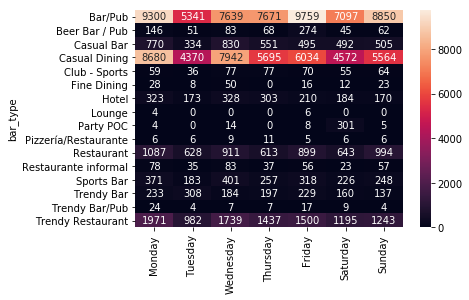

In [26]:
# sharable by day of week and bar/type

pv = sh.pivot_table(values= "order_id", columns ='order_day_of_week', index="bar_type",aggfunc="count", fill_value =0)
pv.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(pv, annot=True, fmt = "d")

### Interesting, it seems that by days of the week, in Bar/pub the trend stands, where sharable foods are eaten mostly on fridays, but not in casual dining.

## days of the week

In [28]:
len(sh)

135179

In [322]:
sh['order_hour'] = sh.order_time.apply(lambda ticket: int(ticket.hour))

/Users/danielastepanov/miniconda3/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


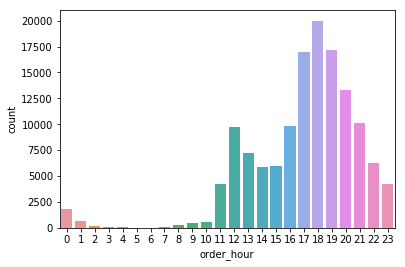

In [27]:
sh_bar = sh[sh.bar_type == "Bar/Pub"]
sns.countplot(x='order_hour', data=sh)

In [31]:
not_sh = df2[df2.sharable == 0]

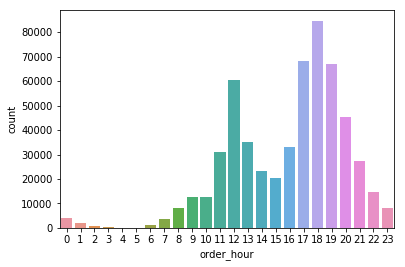

In [33]:
sns.countplot(x='order_hour', data=not_sh)

### this could be saying happy hour, but its a but close to dinner as well.

In [326]:
df["sharable"] = df.title.apply(lambda x: find_sharable(x))

### What about number of guests?

In [318]:
sh.guest_count.value_counts()

1      36447
0      31644
2      25281
3      11527
4       7968
5       3759
6       2225
7       1238
8        875
9        556
10       447
11       246
12       171
16       122
15       120
13       100
14        97
17        89
18        89
19        54
28        44
27        41
66        34
40        32
20        32
25        25
23        24
21        24
39        21
22        19
38        19
24        18
43        17
61        14
26        10
57        10
30         7
35         6
31         5
29         4
52         2
47         2
37         2
34         2
62         2
100        1
49         1
51         1
99         1
65         1
Name: guest_count, dtype: int64

### bar type foods are almost 20% of all foods o.o

### Now lets decide what prices are look like appetizer/small meals.
### I want to know this so that later when we count how many "meal" numbers there are per order, and we don't count the appetizers towards the total meal numbers, which we will use later to count guest count.

In [293]:
cheap_meals = df2[df2.sales_before_tax <= 5]
cheap_meals["title"].value_counts()

WINGS                         4423
SKIP.ORD.#                    2374
---SEAT                       2117
K.COOKIE                      2037
K.BROWNIE                     1798
Side.Caesar                   1772
$Sub.Swt.Pot.Fry-             1768
BOARD NACHOS                  1602
WINGS..                       1547
**                            1519
WED WING                      1481
FAJ.FOR.1                     1350
Salmon.Rice/Veg               1291
K.SORBET                      1248
PAD THAI                      1105
FRIES                         1097
HH WING                       1026
K.ICECREAM                     999
CALAMARI                       956
Mashed                         943
TRAD.GUAC                      893
20 Cent Wings                  891
JACKS.VEG.NACHOS               849
WING WEDNESDAY                 832
OPEN FOOD                      817
Side.House                     758
BACON                          738
Chikn.Rice/Veg                 730
NACHOS              

### honestly it doesn't seem like there's much I can see that decides a certain food is an appetizer:( it seems like theres a lot of noise that needs to be cleaned from the titles.

In [255]:
len(df2["title"].value_counts())

24410